<a href="https://colab.research.google.com/github/Nightskull100/Dress-Type-Detection-using-CNN/blob/main/Project%20V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25 - Train Loss: 0.6240, Validation Loss: 0.4501, Validation Accuracy: 83.53%
Epoch 2/25 - Train Loss: 0.4972, Validation Loss: 0.4189, Validation Accuracy: 84.69%
Epoch 3/25 - Train Loss: 0.4547, Validation Loss: 0.4158, Validation Accuracy: 84.63%
Epoch 4/25 - Train Loss: 0.4470, Validation Loss: 0.3867, Validation Accuracy: 85.61%
Epoch 5/25 - Train Loss: 0.4307, Validation Loss: 0.3814, Validation Accuracy: 85.61%
Epoch 6/25 - Train Loss: 0.4154, Validation Loss: 0.3822, Validation Accuracy: 86.01%
Epoch 7/25 - Train Loss: 0.4113, Validation Loss: 0.3712, Validation Accuracy: 86.29%
Epoch 8/25 - Train Loss: 0.3984, Validation Loss: 0.3929, Validation Accuracy: 85.85%
Epoch 9/25 - Train Loss: 0.3966, Validation Loss: 0.3630, Validation Accuracy: 86.83%
Epoch 10/25 - Train Loss: 0.3907, Validation Loss: 0.3862, Validation Accuracy: 85.80%
Epoch 11/25 - Train Loss: 0.3892, Validation Loss: 0.3631, Validation Accuracy: 86.98%
Epoch 12/25 - Train Loss: 0.3847, Validation Loss: 0

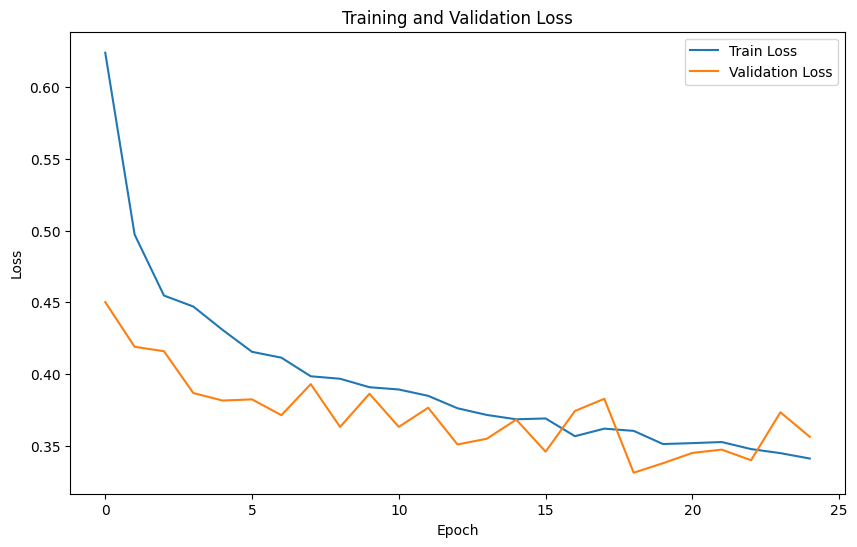

Test Accuracy: 86.90%


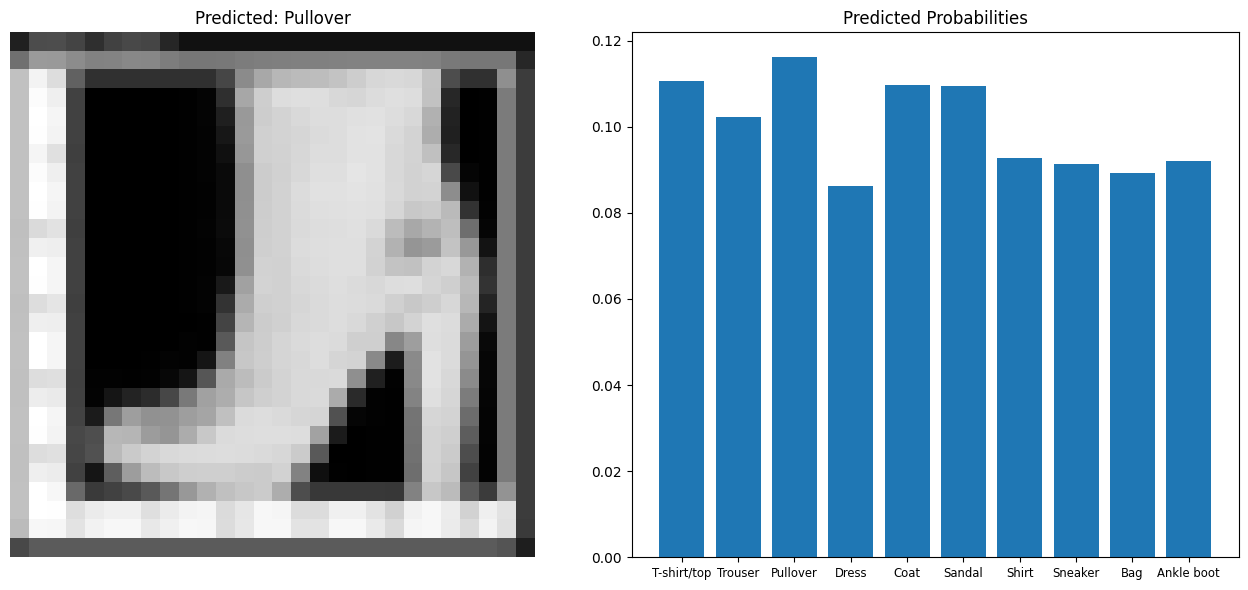

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# Data preparation functions
def get_datasets():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
    test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)
    return train_ds, test_ds

def get_data_loaders(train_ds, batch_size=64, valid_size=0.2):
    train_num = len(train_ds)
    indices = list(range(train_num))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * train_num))
    val_idx, train_idx = indices[:split], indices[split:]

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

# Network definition
def build_network(input_size=784, output_size=10):
    model = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, 128)),
        ('relu1', nn.ReLU()),
        ('drop1', nn.Dropout(0.25)),
        ('fc2', nn.Linear(128, 64)),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(0.25)),
        ('output', nn.Linear(64, output_size)),
        ('logsoftmax', nn.LogSoftmax(dim=1))
    ]))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device

# Training and validation functions
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0
    accuracy = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)

            output = model(images)
            loss = loss_fn(output, labels)
            running_loss += loss.item()

            # Calculate accuracy
            proba = torch.exp(output)
            _, preds = proba.topk(1, dim=1)
            correct = preds.eq(labels.view_as(preds)).sum()
            accuracy += correct.item() / len(labels)

    return running_loss / len(val_loader), accuracy / len(val_loader)

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=25):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_acc*100:.2f}%")

    plot_losses(train_losses, val_losses)

# Plotting function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Test function
def test_model(model, test_loader, device):
    model.eval()
    test_accuracy = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)

            output = model(images)
            proba = torch.exp(output)
            _, preds = proba.topk(1, dim=1)
            correct = preds.eq(labels.view_as(preds)).sum()
            test_accuracy += correct.item() / len(labels)

    print(f"Test Accuracy: {test_accuracy / len(test_loader) * 100:.2f}%")

# Image preprocessing and prediction functions
def preprocess_image(image_url):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    try:
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert('RGB')
    except requests.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except IOError as e:
        print(f"Error opening image: {e}")
        return None

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

def predict_image(model, image_tensor, device):
    model.eval()

    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_tensor = image_tensor.view(image_tensor.shape[0], -1)
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), probabilities.squeeze()

def identify_image(model, image_url, device):
    image_tensor = preprocess_image(image_url)
    if image_tensor is None:
        print("Failed to preprocess image.")
        return

    predicted_class, proba = predict_image(model, image_tensor, device)
    image_np = image_tensor.squeeze().cpu().numpy()

    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
    ax1.imshow(image_np, cmap='gray')
    ax1.axis('off')
    ax1.set_title(f"Predicted: {desc[predicted_class]}")

    ax2.bar(range(10), proba.cpu().numpy())
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small')
    ax2.set_title('Predicted Probabilities')

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    train_ds, test_ds = get_datasets()
    train_loader, val_loader = get_data_loaders(train_ds)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

    model, loss_fn, optimizer, device = build_network()
    train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, device)

    test_model(model, test_loader, device)

if __name__ == "__main__":
    main()

# Example usage for image identification
desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
image_url = 'https://github.com/sssingh/fashion-mnist-classification/blob/master/assets/fmnist_single_image.png?raw=true'
identify_image(model, image_url, device)


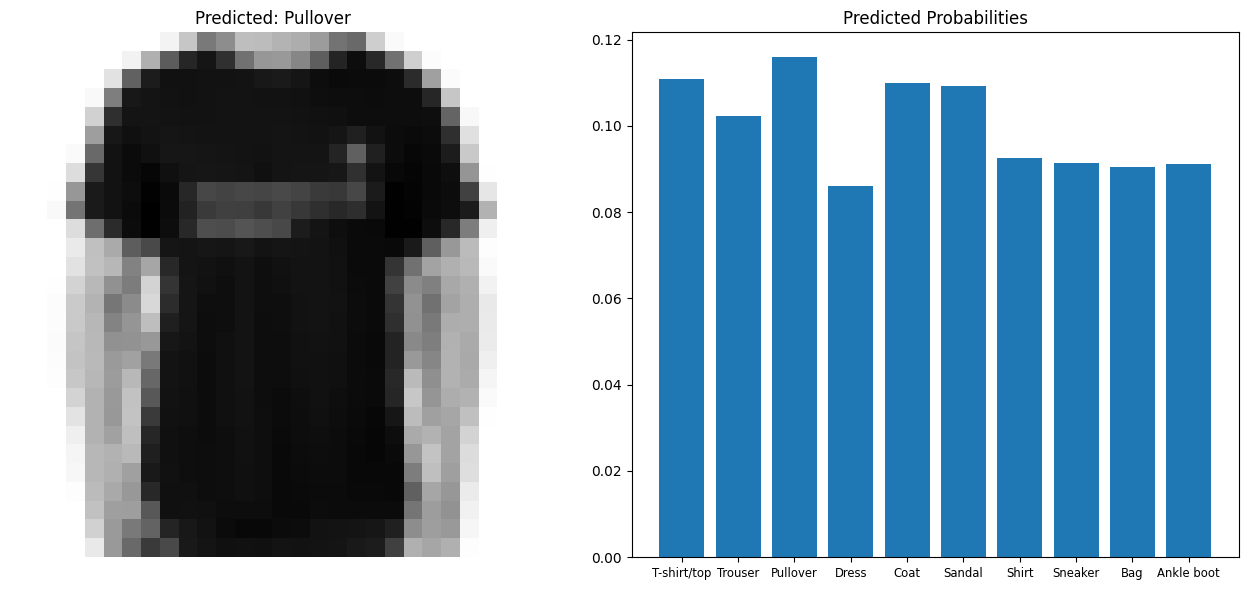

In [ ]:
image_url = 'https://m.media-amazon.com/images/I/51yDCOw4VWL._SX679_.jpg'
identify_image(model, image_url, device)